# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [ ]:
import numpy as np

In [ ]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [ ]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<Axes: >

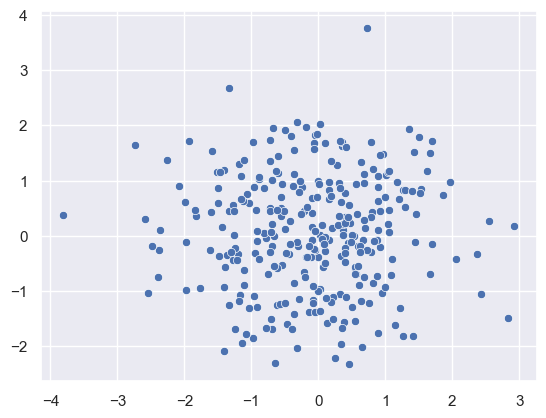

In [32]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

<Axes: >

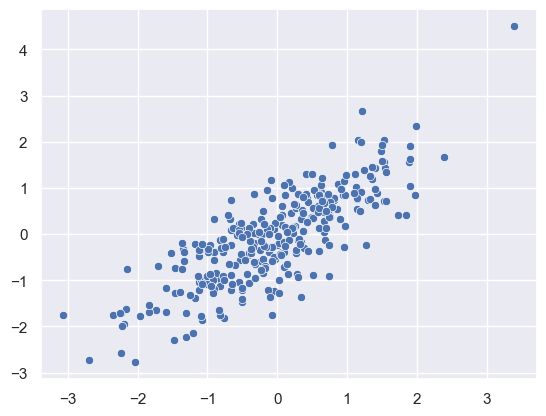

In [33]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [ ]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [22]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))#.cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))#.cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [ ]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

In [25]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [26]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [ ]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [ ]:
mine_net_indep = Mine()#.cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

In [ ]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [ ]:
mine_net_cor = Mine()#.cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

In [ ]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [ ]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

In [ ]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

In [ ]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [ ]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

In [ ]:
sns.scatterplot(x, f1,color='red')

In [ ]:
sns.scatterplot(x, f2,color='blue')

In [ ]:
sns.scatterplot(x, f3,color='green')

In [ ]:
sns.scatterplot(x, f4,color='purple')

In [ ]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

In [ ]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
        result = train(data,mine_net,mine_net_optim,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [ ]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

In [ ]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)